## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import three relevant datasets
CAT_FILENAME = r'data\exoplanet.eu_catalog_08-01-26_13_03_00.csv'
df_cat = pd.read_csv(CAT_FILENAME)
df_cat.head(3)

,name,planet_status,mass,mass_error_min,mass_error_max,mass_sini,mass_sini_error_min,mass_sini_error_max,radius,radius_error_min,...,star_sp_type,star_age,star_age_error_min,star_age_error_max,star_teff,star_teff_error_min,star_teff_error_max,star_detected_disc,star_magnetic_field,star_alternate_names
0,109 Psc b,Confirmed,5.743,0.289,1.011,6.383,0.078,0.078,1.152,NaN,...,G5 IV,6.9,0.6,0.6,5600.0,80.000,80.000,NaN,NaN,HD 10697
1,112 Psc b,Confirmed,NaN,0.005,0.004,0.033,0.005,0.004,NaN,NaN,...,G0IV,NaN,NaN,NaN,5986.0,105.437,105.437,NaN,NaN,HD 12235
2,112 Psc c,Confirmed,9.866,1.781,3.190,NaN,NaN,NaN,NaN,NaN,...,G0IV,NaN,NaN,NaN,5986.0,105.437,105.437,NaN,NaN,HD 12235


In [3]:
MID_FILENAME = r'data\ExoClock IV Ephemerides_20260107\mid_time_data\all_mid_time_data.txt'
df_mid = pd.read_csv(MID_FILENAME, sep='\s+')
df_mid.head(3)

,Planet,Tmid_(BJD_TDB),Tmid_unc.,source,ID
0,55Cnce,2.455607e+06,0.00087,literature,2011ApJ...737L..18W
1,55Cnce,2.458871e+06,0.00066,space,55Cnce_9945_2020-01-22_TESS
2,55Cnce,2.458871e+06,0.00230,space,55Cnce_9946_2020-01-22_TESS


In [4]:
T0P_FILENAME = r'data\ExoClock IV Ephemerides_20260107\catalogue_of_ephemerides.txt'
df_t0p = pd.read_csv(T0P_FILENAME, sep='\s+')
df_t0p.tail(3)

,Planet,T0_(BJD_TDB),T0_unc.,P_(days),P_unc.
617,XO-6b,2.459424e+06,0.000070,3.764992,4.600000e-07
618,XO-7b,2.459567e+06,0.000072,2.864133,4.700000e-07
619,piMenc,2.459385e+06,0.000150,6.267821,1.300000e-06


## Clean exoplanet.eu dataset then merge with T0P

In [5]:
print(df_cat.columns)

Index(['name', 'planet_status', 'mass', 'mass_error_min', 'mass_error_max',
       'mass_sini', 'mass_sini_error_min', 'mass_sini_error_max', 'radius',
       'radius_error_min', 'radius_error_max', 'orbital_period',
       'orbital_period_error_min', 'orbital_period_error_max',
       'semi_major_axis', 'semi_major_axis_error_min',
       'semi_major_axis_error_max', 'eccentricity', 'eccentricity_error_min',
       'eccentricity_error_max', 'inclination', 'inclination_error_min',
       'inclination_error_max', 'angular_distance', 'discovered', 'updated',
       'omega', 'omega_error_min', 'omega_error_max', 'tperi',
       'tperi_error_min', 'tperi_error_max', 'tconj', 'tconj_error_min',
       'tconj_error_max', 'tzero_tr', 'tzero_tr_error_min',
       'tzero_tr_error_max', 'tzero_tr_sec', 'tzero_tr_sec_error_min',
       'tzero_tr_sec_error_max', 'lambda_angle', 'lambda_angle_error_min',
       'lambda_angle_error_max', 'impact_parameter',
       'impact_parameter_error_min', 'impa

In [6]:
# Select cols
relevant_columns = ['name', 'mass', 'mass_error_min', 'mass_error_max',
                    'mass_sini', 'mass_sini_error_min', 'mass_sini_error_max',
                    'radius', 'radius_error_min', 'radius_error_max',
                    'orbital_period', 'orbital_period_error_min', 'orbital_period_error_max',
                    'eccentricity', 'eccentricity_error_min', 'eccentricity_error_max',
                    'inclination', 'inclination_error_min', 'inclination_error_max',
                    'omega', 'omega_error_min', 'omega_error_max',
                    'star_mass', 'star_mass_error_min', 'star_mass_error_max',
                    'star_radius', 'star_radius_error_min', 'star_radius_error_max',
                    'alternate_names', 'star_name']
df_cat_relevant = df_cat[relevant_columns]

# Pick error as larger error of the two
params = ['mass', 'mass_sini', 'radius', 'orbital_period', 'eccentricity', 'omega', 'inclination', 'star_mass', 'star_radius']
for p in params:
    df_cat_relevant = df_cat_relevant.copy()
    df_cat_relevant[f'{p}_error'] = df_cat_relevant[[f'{p}_error_min', f'{p}_error_max']].abs().max(axis=1)
df_cat_relevant = df_cat_relevant[['name', 'alternate_names', 'star_name', *[col for p in params for col in (f'{p}', f'{p}_error')]]]

# Merge with new good column _key with appropriate formatting
df_left, df_right = df_t0p.copy(), df_cat_relevant.copy()
# left key: Remove final Ab -> b and such
df_left['_key'] = df_left['Planet'].str.replace(r'([A-Za-z0-9])([AB])([a-z])$', r'\1\3', regex=True)
# Right key: Strip whitespace then Remove final Ab -> b and such too 
df_right['_key'] = df_right['name'].str.replace(' ', '', regex=False) \
                   .str.replace(r'([AB])([a-z])$', r'\2', regex=True)

# Manual key mapping for the rest (Alternate names for the rest)
rename_map = {
    'K2-236b': 'EPIC211945201b',
    'K2-267b': 'EPIC246851721b',
    # None: 'GJ436b', # Exists in exoplanet.eu / RV
    'TOI-1098b': 'HD110082b',
    'nu2Lupb': 'HD136352c',
    # None: 'HD209458b', # Exists in exoplanet.eu / RV
    'TOI-1430b': 'HD235088b',
    'TOI-282c': 'HD28109c',
    'TOI-282d': 'HD28109d',
    'TOI-396b': 'HR858b',
    'WASP-122b': 'KELT-14b',
    'MASCARA-3b': 'KELT-24b',
    # None: 'KELT-4Ab', # Exists in exoplanet.eu / RV
    'Kepler-448b': 'KOI-12b',
    'Kepler-13b': 'KOI-13b',
    'Kepler-89c': 'KOI-94c',
    'Kepler-89d': 'KOI-94d',
    'Kepler-89e': 'KOI-94e',
    # None: 'Kepler-76b', # Exists in exoplanet.eu / Other
    # None: 'Kepler-854b', # False positive planet
    # None: 'TIC257060897b', # Exists but not in TEPCat
    'TOI-150b': 'TOI-150.01',
    'TOI-216c': 'TOI-216.01',
    'TOI-216b': 'TOI-216.02',
    'HAT-P-10b': 'WASP-11b',
    'KELT-22b': 'WASP-173b'
}
df_right['_key'] = df_right['_key'].replace(rename_map)

df_right.head(3)

,name,alternate_names,star_name,mass,mass_error,mass_sini,mass_sini_error,radius,radius_error,orbital_period,...,eccentricity_error,omega,omega_error,inclination,inclination_error,star_mass,star_mass_error,star_radius,star_radius_error,_key
0,109 Psc b,HD 10697 b,109 Psc,5.743,1.011,6.383,0.078,1.152,NaN,1075.4,...,0.009,112.816,5.448,86.116,20.530,1.13,0.030,1.790,0.1700,109Pscb
1,112 Psc b,HD 12235 b,112 Psc,NaN,0.005,0.033,0.005,NaN,NaN,4.4,...,0.254,279.492,67.524,NaN,NaN,1.10,0.133,1.801,0.0725,112Pscb
2,112 Psc c,HD 12235 c,112 Psc,9.866,3.190,NaN,NaN,NaN,NaN,36336.7,...,0.154,79.772,31.067,47.738,12.651,1.10,0.133,1.801,0.0725,112Pscc


In [7]:
# Test to see output
df_left.to_csv(r"data_intermediate\df_left_test.csv", index=False)
df_right.to_csv(r"data_intermediate\df_right_test.csv", index=False)

# Merge~!
df_t0p_cat = df_left.merge(
    df_right,
    on='_key',
    how='left'
).drop(columns='_key')

# Drop 'alternate_names' cols
df_t0p_cat = df_t0p_cat.drop(columns=['alternate_names'])
# Differentiate between ExoClock name and exoplanet.eu name
df_t0p_cat = df_t0p_cat.rename(columns={
    'Planet': 'name_exoclock',
    'name': 'name_exoplanet.eu',
})
# Export and show
EXPORT_FILENAME = r'data_intermediate\merged_exoclock_exoplanet.eu.csv'
df_t0p_cat.to_csv(EXPORT_FILENAME, index=False)
df_t0p_cat.tail(3)

,name_exoclock,T0_(BJD_TDB),T0_unc.,P_(days),P_unc.,name_exoplanet.eu,star_name,mass,mass_error,mass_sini,...,eccentricity,eccentricity_error,omega,omega_error,inclination,inclination_error,star_mass,star_mass_error,star_radius,star_radius_error
618,XO-6b,2.459424e+06,0.000070,3.764992,4.600000e-07,XO-6 b,XO-6,4.47000,0.1200,NaN,...,0.000,NaN,NaN,NaN,85.060,0.07,1.470,0.060,1.93,0.180
619,XO-7b,2.459567e+06,0.000072,2.864133,4.700000e-07,XO-7 b,XO-7,0.72600,0.0380,NaN,...,0.038,0.033,NaN,NaN,83.230,0.01,1.405,0.059,1.48,0.022
620,piMenc,2.459385e+06,0.000150,6.267821,1.300000e-06,pi Men c,pi Men,0.01142,0.0012,NaN,...,0.150,0.150,NaN,NaN,87.553,0.18,1.094,0.039,1.10,0.023


In [8]:
# Check removed left
removed_left = sorted(set(df_t0p['Planet']) - set(df_t0p_cat['name_exoclock']))
removed_left

[]

## Get O-C for each mid-transit

In [9]:
# Merge by planet
df_OC = df_mid.merge(df_t0p, on='Planet', how='left')

# Acquire epoch and finally O-C [+err]
df_OC['epoch'] = np.int64(np.round(
    (df_OC['Tmid_(BJD_TDB)'] - df_OC['T0_(BJD_TDB)']) / df_OC['P_(days)']
))
df_OC['O-C_(days)'] = df_OC['Tmid_(BJD_TDB)'] - (df_OC['T0_(BJD_TDB)'] + df_OC['epoch']*df_OC['P_(days)']) 	
df_OC['O-C_unc._(days)'] = df_OC['Tmid_unc.'] + df_OC['T0_unc.'] + np.abs(
    (df_OC['epoch'] * df_OC['P_unc.'])
)

# Drop unused columns
df_OC = df_OC.drop(columns=['ID', 'T0_(BJD_TDB)', 'T0_unc.', 'P_(days)', 'P_unc.'])

# Exoport and show
EXPORT_FILENAME = r'data_cleaned\all_mid_time_data_with_OC.csv'
df_OC.to_csv(EXPORT_FILENAME, index=False)
df_OC.head(3)

,Planet,Tmid_(BJD_TDB),Tmid_unc.,source,epoch,O-C_(days),O-C_unc._(days)
0,55Cnce,2.455607e+06,0.00087,literature,-5359,0.000810,0.00172
1,55Cnce,2.458871e+06,0.00066,space,-928,-0.003537,0.00089
2,55Cnce,2.458871e+06,0.00230,space,-927,-0.003004,0.00253


In [10]:
# Get Number of transits recorded
df_counts = (
    df_OC['Planet']
    .value_counts()
    .reset_index(name='midtime_counts')
    .rename(columns={'index': 'Planet'})
)
df_counts.head()

,Planet,midtime_counts
0,KOI-13b,811
1,Kepler-41b,703
2,HAT-P-7b,686
3,Kepler-17b,664
4,Kepler-76b,649


In [11]:
# Merge into df_t0p_cat, re-export and show
df_t0p_cat_count = df_t0p_cat.merge(
    df_counts,
    left_on='name_exoclock', right_on='Planet',
    how='left'
).drop(columns='Planet')

EXPORT_FILENAME = r'data_intermediate\merged_exoclock_exoplanet.eu+counts.csv'
df_t0p_cat_count.to_csv(EXPORT_FILENAME, index=False)
df_t0p_cat_count.tail(3)

,name_exoclock,T0_(BJD_TDB),T0_unc.,P_(days),P_unc.,name_exoplanet.eu,star_name,mass,mass_error,mass_sini,...,eccentricity_error,omega,omega_error,inclination,inclination_error,star_mass,star_mass_error,star_radius,star_radius_error,midtime_counts
618,XO-6b,2.459424e+06,0.000070,3.764992,4.600000e-07,XO-6 b,XO-6,4.47000,0.1200,NaN,...,NaN,NaN,NaN,85.060,0.07,1.470,0.060,1.93,0.180,89
619,XO-7b,2.459567e+06,0.000072,2.864133,4.700000e-07,XO-7 b,XO-7,0.72600,0.0380,NaN,...,0.033,NaN,NaN,83.230,0.01,1.405,0.059,1.48,0.022,92
620,piMenc,2.459385e+06,0.000150,6.267821,1.300000e-06,pi Men c,pi Men,0.01142,0.0012,NaN,...,0.150,NaN,NaN,87.553,0.18,1.094,0.039,1.10,0.023,64


## Get data for the rest of the planets in systems present in df_t0p_cat_count

In [12]:
common_stars = set(df_t0p_cat_count['star_name']).intersection(df_cat['star_name'])
df_cat_otherplanets = df_cat[df_cat['star_name'].isin(common_stars)][relevant_columns]

# Pick error as larger error of the two (Copypasted!)
params = ['mass', 'mass_sini', 'radius', 'orbital_period', 'eccentricity', 'omega', 'inclination', 'star_mass', 'star_radius']
for p in params:
    df_cat_otherplanets = df_cat_otherplanets.copy()
    df_cat_otherplanets[f'{p}_error'] = df_cat_otherplanets[[f'{p}_error_min', f'{p}_error_max']].abs().max(axis=1)
df_cat_otherplanets = df_cat_otherplanets[['name', 'alternate_names', 'star_name', *[col for p in params for col in (f'{p}', f'{p}_error')]]]

# rename 'name' to 'name_exoplanet.eu'
df_cat_otherplanets = df_cat_otherplanets.rename(columns={
    'name': 'name_exoplanet.eu',
})

# Outer merge with df_t0p_cat_count
common_colnames = df_cat_otherplanets.columns.intersection(df_t0p_cat_count.columns).tolist()
df_t0p_cat_count_otherplanets = df_t0p_cat_count.merge(
    df_cat_otherplanets, on=common_colnames, how='outer'
).drop(columns='alternate_names')

# Counts unique planets per star_names and broadcasts back to all rows
planet_count_per_system = (
    df_t0p_cat_count_otherplanets.groupby('star_name')['name_exoplanet.eu']
    .nunique()
)
df_t0p_cat_count_otherplanets['planet_count'] = df_t0p_cat_count_otherplanets['star_name'].map(planet_count_per_system)

# As cleanup, remove rows where 'name_exoclock' AND 'star_name' are NaN
df_t0p_cat_count_otherplanets = df_t0p_cat_count_otherplanets.dropna(subset=['name_exoclock', 'star_name'], how='all')
# Remove Kepler-854b row because it's false positive
df_t0p_cat_count_otherplanets = df_t0p_cat_count_otherplanets[df_t0p_cat_count_otherplanets['name_exoclock'] != 'Kepler-854b']
# Direct value insertion for TIC 257060897
mask = (df_t0p_cat_count_otherplanets['name_exoclock'] == 'TIC257060897b')
df_t0p_cat_count_otherplanets.loc[mask, ['star_name', 'planet_count']] = ['TIC 257060897', 1]

# Export
EXPORT_FILENAME = r'data_cleaned\merged_exoclock_exoplanet.eu+counts+otherplanets.csv'
df_t0p_cat_count_otherplanets.to_csv(EXPORT_FILENAME, index=False)
df_t0p_cat_count_otherplanets.tail(3)

,name_exoclock,T0_(BJD_TDB),T0_unc.,P_(days),P_unc.,name_exoplanet.eu,star_name,mass,mass_error,mass_sini,...,omega,omega_error,inclination,inclination_error,star_mass,star_mass_error,star_radius,star_radius_error,midtime_counts,planet_count
792,piMenc,2.459385e+06,0.00015,6.267821,0.000001,pi Men c,pi Men,0.01142,0.00120,NaN,...,NaN,NaN,87.553,0.18,1.094,0.039,1.1,0.023,64.0,3.0
793,NaN,NaN,NaN,NaN,NaN,pi Men d,pi Men,NaN,0.00425,0.0421,...,323.0,73.0,NaN,NaN,1.094,0.039,1.1,0.023,NaN,3.0
795,TIC257060897b,2.459423e+06,0.00019,3.660035,0.000002,NaN,TIC 257060897,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,1.0


## Fill in missing values with the NASA exoplanet database

In [65]:
# Import
NASA_FILENAME = r'data\PS_2026.01.13_23.21.34.csv'
df_nasa = pd.read_csv(NASA_FILENAME, comment='#')
df_nasa.head(3)

,pl_name,hostname,pl_letter,sy_snum,sy_pnum,etv_flag,soltype,pl_controv_flag,pl_refname,pl_radj,...,st_raderr1,st_raderr2,st_radlim,st_mass,st_masserr1,st_masserr2,st_masslim,rowupdate,pl_pubdate,releasedate
0,11 Com b,11 Com,b,2,1,0,Published Confirmed,0,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...,NaN,...,2.85,-2.45,0.0,2.09,0.64,-0.63,0.0,2023-09-19,2023-08,2023-09-19
1,11 Com b,11 Com,b,2,1,0,Published Confirmed,0,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,NaN,...,2.00,-2.00,0.0,2.70,0.30,-0.30,0.0,2014-05-14,2008-01,2014-05-14
2,11 Com b,11 Com,b,2,1,0,Published Confirmed,0,<a refstr=KUNITOMO_ET_AL__2011 href=https://ui...,NaN,...,NaN,NaN,NaN,2.60,0.40,-0.30,0.0,2014-07-23,2011-08,2014-07-23


In [66]:
# Sort by publication date, from latest
df_nasa_right = df_nasa.copy()
df_nasa_right['pl_pubdate'] = pd.to_datetime(df_nasa_right['pl_pubdate'], errors='coerce').dt.date

df_nasa_right = df_nasa_right.sort_values(['pl_name', 'pl_pubdate'], ascending=[True, False])

def move_to_last_col(df, col):
    return df[[c for c in df.columns if c != col] + [col]]
df_nasa_right = move_to_last_col(df_nasa_right, 'pl_refname')
df_nasa_right = move_to_last_col(df_nasa_right, 'st_refname')

df_nasa_right.head(3)

,pl_name,hostname,pl_letter,sy_snum,sy_pnum,etv_flag,soltype,pl_controv_flag,pl_radj,pl_radjerr1,...,st_radlim,st_mass,st_masserr1,st_masserr2,st_masslim,rowupdate,pl_pubdate,releasedate,pl_refname,st_refname
0,11 Com b,11 Com,b,2,1,0,Published Confirmed,0,NaN,NaN,...,0.0,2.09,0.64,-0.63,0.0,2023-09-19,2023-08-01,2023-09-19,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...
2,11 Com b,11 Com,b,2,1,0,Published Confirmed,0,NaN,NaN,...,NaN,2.60,0.40,-0.30,0.0,2014-07-23,2011-08-01,2014-07-23,<a refstr=KUNITOMO_ET_AL__2011 href=https://ui...,<a refstr=KUNITOMO_ET_AL__2011 href=https://ui...
1,11 Com b,11 Com,b,2,1,0,Published Confirmed,0,NaN,NaN,...,0.0,2.70,0.30,-0.30,0.0,2014-05-14,2008-01-01,2014-05-14,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...


In [67]:
# Choose error with greater magnitude as error
params = ['pl_radj', 'pl_massj', 'pl_msinij', 'pl_orbeccen', 'pl_orbincl', 'pl_orblper', 'st_rad', 'st_mass']
for p in params:
    df_nasa_right = df_nasa_right.copy()
    df_nasa_right[f'{p}_err'] = df_nasa_right[[f'{p}err1', f'{p}err2']].abs().max(axis=1)

# Rearrange cols
cols = ['pl_name', 'hostname', 'pl_letter',	'sy_snum', 'sy_pnum', 'etv_flag', 'ttv_flag', 'soltype', 'pl_controv_flag', 
        *[col for p in params for col in (f'{p}', f'{p}_err')],
        'pl_pubdate', 'pl_refname', 'st_refname']	
df_nasa_right = df_nasa_right[cols]

df_nasa_right.head(3)

,pl_name,hostname,pl_letter,sy_snum,sy_pnum,etv_flag,ttv_flag,soltype,pl_controv_flag,pl_radj,...,pl_orbincl_err,pl_orblper,pl_orblper_err,st_rad,st_rad_err,st_mass,st_mass_err,pl_pubdate,pl_refname,st_refname
0,11 Com b,11 Com,b,2,1,0,0.0,Published Confirmed,0,NaN,...,NaN,91.33,1.8,13.76,2.85,2.09,0.64,2023-08-01,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...
2,11 Com b,11 Com,b,2,1,0,0.0,Published Confirmed,0,NaN,...,NaN,NaN,NaN,NaN,NaN,2.60,0.40,2011-08-01,<a refstr=KUNITOMO_ET_AL__2011 href=https://ui...,<a refstr=KUNITOMO_ET_AL__2011 href=https://ui...
1,11 Com b,11 Com,b,2,1,0,0.0,Published Confirmed,0,NaN,...,NaN,94.80,1.5,19.00,2.00,2.70,0.30,2008-01-01,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...


In [68]:
# Create 6 separate dfs for data that has valid radj, massj, msinij, orbeccen, orbincl, orblper at latest publication date
def filter_df_by_nonan_col(df, col, mode='pl'):
    mask_cols = [f'{col}', f'{col}_err', f'pl_pubdate']
    mask = df[mask_cols].notna().all(axis=1)
    df_masked = df[mask]
    df_latestpub = df_masked.loc[df_masked.groupby('pl_name')[f'pl_pubdate'].idxmax()]

    # Rename column
    df_latestpub = df_latestpub.rename(columns={
        'pl_pubdate': f'{col}_pubdate',
        f'{mode}_refname': f'{col}_refname',
    })

    # Stellar-wise: take latest stellar parameter per host, then map to all planets
    if mode == 'st':
        idx = df_latestpub.groupby('hostname')[f'{col}_pubdate'].idxmax()
        stellar_latest = df_latestpub.loc[idx, ['hostname', col, f'{col}_err',
                                                f'{col}_pubdate', f'{col}_refname']]
        df_latestpub = df_latestpub.drop(columns=[col, f'{col}_err',
                                                  f'{col}_pubdate', f'{col}_refname'])
        df_latestpub = df_latestpub.merge(stellar_latest, on='hostname', how='left')
    
    exclusive_cols = cols[:3] + mask_cols[:2] + [f'{col}_pubdate', f'{col}_refname']
    return df_latestpub[exclusive_cols]

df_list = [filter_df_by_nonan_col(df_nasa_right, pcol, mode=pcol[:2]) for pcol in params]
keys = cols[:3]

# Merging time!
df_nasa_right_latest = (
    df_list[0].merge(df_list[1], on=keys, how='outer')
       .merge(df_list[2], on=keys, how='outer')
       .merge(df_list[3], on=keys, how='outer')
       .merge(df_list[4], on=keys, how='outer')
       .merge(df_list[5], on=keys, how='outer')
       .merge(df_list[6], on=keys, how='outer')
       .merge(df_list[7], on=keys, how='outer')
)
EXPORT_FILENAME = r'data_intermediate\nasa_tofillnans.csv'
df_nasa_right_latest.to_csv(EXPORT_FILENAME, index=False)
df_nasa_right_latest.head(3)

,pl_name,hostname,pl_letter,pl_radj,pl_radj_err,pl_radj_pubdate,pl_radj_refname,pl_massj,pl_massj_err,pl_massj_pubdate,...,pl_orblper_pubdate,pl_orblper_refname,st_rad,st_rad_err,st_rad_pubdate,st_rad_refname,st_mass,st_mass_err,st_mass_pubdate,st_mass_refname
0,11 Com b,11 Com,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2023-08-01,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...,13.76,2.85,2023-08-01,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...,2.09,0.64,2023-08-01,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...
1,11 UMi b,11 UMi,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2009-10-01,<a refstr=DOLLINGER_ET_AL__2009 href=https://u...,29.79,2.84,2017-03-01,<a refstr=STASSUN_ET_AL__2017 href=https://ui....,2.78,0.69,2017-03-01,<a refstr=STASSUN_ET_AL__2017 href=https://ui....
2,14 And b,14 And,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,11.55,1.12,2023-08-01,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...,1.78,0.43,2023-08-01,<a refstr=TENG_ET_AL__2023 href=https://ui.ads...


In [69]:
# Merge with hostname as key
# The exoclock planet names are simply the NASA Exoplanet Database stripped strings.

# key01: host name
df_t0p_cat_count_otherplanets_left = df_t0p_cat_count_otherplanets.copy()
df_t0p_cat_count_otherplanets_left['_key01'] = (
    df_t0p_cat_count_otherplanets['name_exoclock']
    # 1) remove final lowercase letter
    .str.replace(r'[a-z]$', '', regex=True)
    # 2) put space before final capital letter (planet host)
    .str.replace(r'([A-Z])$', r' \1', regex=True)
    # 3) add space between leading letters and numbers (only if no hyphen)
    .str.replace(r'^([A-Z]+)(\d)', r'\1 \2', regex=True)
    # EXCEPTION: undo space for K2
    .str.replace(r'^K 2-', 'K2-', regex=True)
)
# Manual key01 replacement (5 edge cases)
replacements = {
    r'^55Cnc$': '55 Cnc',
    r'^TOI-150\.01$': 'TOI-150',
    r'^TOI-2152 A$': 'TOI-2152',
    r'^TOI-216\.0[12]$': 'TOI-216',
    r'^piMen$': 'HD 39091',
}
df_t0p_cat_count_otherplanets_left['_key01'] = df_t0p_cat_count_otherplanets_left['_key01'].replace(replacements, regex=True)
# Project the obtained key01 to the rest of the rows with shared 'star_name'
df_t0p_cat_count_otherplanets_left['_key01'] = (
    df_t0p_cat_count_otherplanets_left
    .groupby('star_name')['_key01']
    .transform('first')
)

# key02: planet identifier
df_t0p_cat_count_otherplanets_left['_key02'] = df_t0p_cat_count_otherplanets_left['name_exoplanet.eu'].str[-1]
# Manual key-in
df_t0p_cat_count_otherplanets_left.loc[df_t0p_cat_count_otherplanets_left['name_exoclock'] == 'TIC257060897b', '_key02'] = 'b'

# Merge with key01 and key02 as keys
df_t0p_cat_nasa = df_t0p_cat_count_otherplanets_left.merge(
    df_nasa_right_latest, left_on=['_key01', '_key02'], right_on=['hostname', 'pl_letter'], how='left'
)

EXPORT_FILENAME = r'data_intermediate\merged_exoclock_exoplanet.eu_nasa_merge_beforenanfill.csv'
df_t0p_cat_nasa.to_csv(EXPORT_FILENAME, index=False)
df_t0p_cat_nasa.head(3)

,name_exoclock,T0_(BJD_TDB),T0_unc.,P_(days),P_unc.,name_exoplanet.eu,star_name,mass,mass_error,mass_sini,...,pl_orblper_pubdate,pl_orblper_refname,st_rad,st_rad_err,st_rad_pubdate,st_rad_refname,st_mass,st_mass_err,st_mass_pubdate,st_mass_refname
0,NaN,NaN,NaN,NaN,NaN,55 Cnc Ab,55 Cnc A,0.84,0.2300,0.8400,...,2025-10-01,<a refstr=MOUTOU_ET_AL__2025 href=https://ui.a...,0.98,0.016,2025-10-01,<a refstr=MOUTOU_ET_AL__2025 href=https://ui.a...,1.015,0.051,2025-10-01,<a refstr=MOUTOU_ET_AL__2025 href=https://ui.a...
1,NaN,NaN,NaN,NaN,NaN,55 Cnc Ac,55 Cnc A,NaN,0.0275,0.1784,...,2025-10-01,<a refstr=MOUTOU_ET_AL__2025 href=https://ui.a...,0.98,0.016,2025-10-01,<a refstr=MOUTOU_ET_AL__2025 href=https://ui.a...,1.015,0.051,2025-10-01,<a refstr=MOUTOU_ET_AL__2025 href=https://ui.a...
2,NaN,NaN,NaN,NaN,NaN,55 Cnc Ad,55 Cnc A,NaN,0.0800,3.8400,...,2025-10-01,<a refstr=MOUTOU_ET_AL__2025 href=https://ui.a...,0.98,0.016,2025-10-01,<a refstr=MOUTOU_ET_AL__2025 href=https://ui.a...,1.015,0.051,2025-10-01,<a refstr=MOUTOU_ET_AL__2025 href=https://ui.a...


In [70]:
# Fill in NaN values
def fill_in_nan(df, filled, filler):
    filled_cols = [f'{filled}', f'{filled}_error']
    filler_cols = [f'{filler}', f'{filler}_err']
    
    mask = df[filled_cols].isna().any(axis=1)
    df_filled = df.copy()
    df_filled.loc[mask, filled_cols] = df_filled.loc[mask, filler_cols].to_numpy()
    return df_filled

df_t0p_cat_nasa_filled = df_t0p_cat_nasa.copy()
df_t0p_cat_nasa_filled = fill_in_nan(df_t0p_cat_nasa_filled, 'mass', 'pl_massj')
df_t0p_cat_nasa_filled = fill_in_nan(df_t0p_cat_nasa_filled, 'mass_sini', 'pl_msinij')
df_t0p_cat_nasa_filled = fill_in_nan(df_t0p_cat_nasa_filled, 'radius', 'pl_radj')
df_t0p_cat_nasa_filled = fill_in_nan(df_t0p_cat_nasa_filled, 'eccentricity', 'pl_orbeccen')
df_t0p_cat_nasa_filled = fill_in_nan(df_t0p_cat_nasa_filled, 'omega', 'pl_orblper')
df_t0p_cat_nasa_filled = fill_in_nan(df_t0p_cat_nasa_filled, 'inclination', 'pl_orbincl')
df_t0p_cat_nasa_filled = fill_in_nan(df_t0p_cat_nasa_filled, 'star_mass', 'st_mass')
df_t0p_cat_nasa_filled = fill_in_nan(df_t0p_cat_nasa_filled, 'star_radius', 'st_rad')

# Only the first 27 cols AND plannet letter column
df_t0p_cat_nasa_filled = df_t0p_cat_nasa_filled.iloc[:, list(range(27)) + [df_t0p_cat_nasa_filled.columns.get_loc('pl_letter')]]
# Drop and rearrange certain columns
def move_colname_to_index(df, idx, colname):
    return df.insert(idx, colname, df.pop(colname))

for colname in ['pl_letter', 'star_name', 'name_exoplanet.eu']:
    move_colname_to_index(df_t0p_cat_nasa_filled, 1, colname)

# Export!
EXPORT_FILENAME = r'data_intermediate\merged_exoclock_exoplanet.eu_nasa_merge_afternanfill_01.csv'
df_t0p_cat_nasa_filled.to_csv(EXPORT_FILENAME, index=False)
df_t0p_cat_nasa_filled.head(3)

,name_exoclock,name_exoplanet.eu,star_name,pl_letter,T0_(BJD_TDB),T0_unc.,P_(days),P_unc.,mass,mass_error,...,omega,omega_error,inclination,inclination_error,star_mass,star_mass_error,star_radius,star_radius_error,midtime_counts,planet_count
0,NaN,55 Cnc Ab,55 Cnc A,b,NaN,NaN,NaN,NaN,0.8400,0.2300,...,110.0,54.0,89.73,24.54,0.9,0.115,0.963,0.0654,NaN,5.0
1,NaN,55 Cnc Ac,55 Cnc A,c,NaN,NaN,NaN,NaN,0.1714,0.0055,...,356.0,22.0,89.73,24.54,0.9,0.115,0.963,0.0654,NaN,5.0
2,NaN,55 Cnc Ad,55 Cnc A,d,NaN,NaN,NaN,NaN,3.8780,0.0680,...,254.0,32.0,89.73,24.54,0.9,0.115,0.963,0.0654,NaN,5.0


## Fill in the rest of the missing values!

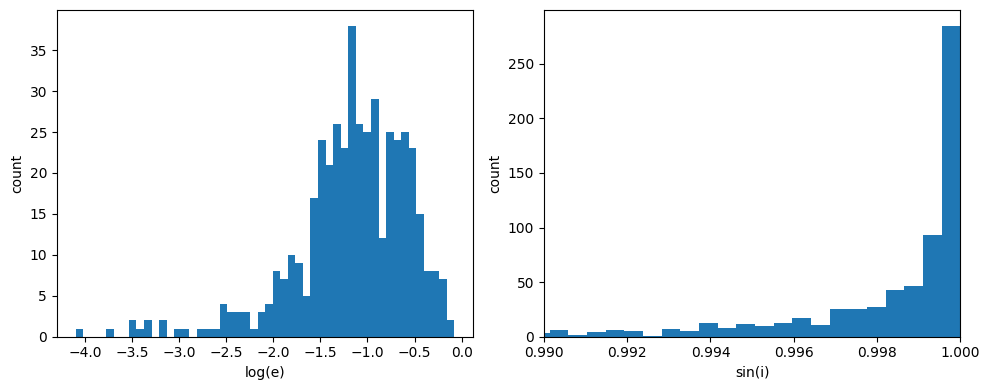

In [71]:
# Distribution of log e and sin i
# log(e)
e = df_t0p_cat_nasa_filled['eccentricity'].dropna()
e = e[e > 0]
loge = np.log10(e)
# sin i
i = df_t0p_cat_nasa_filled['inclination'].dropna()
sini = np.sin(np.deg2rad(i))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(loge, bins=50)
ax[0].set_xlabel('log(e)'); ax[0].set_ylabel('count')

ax[1].hist(sini, bins=1000)
ax[1].set_xlabel('sin(i)'); ax[1].set_ylabel('count')
ax[1].set_xlim(0.99, 1.00)

plt.tight_layout()
plt.show()

In [72]:
# Aggregated e and i by planet_count
def get_aggs(df, val):
    agg_out = df[val].dropna().agg(
        median='median',
        p16=lambda x: x.quantile(0.16),
        p84=lambda x: x.quantile(0.84),
    )
    return agg_out

e_med, e_p16, e_p84 = get_aggs(df_t0p_cat_nasa_filled, 'eccentricity')
loge_med, loge_p16, loge_p84 = np.log10([e_med, e_p16, e_p84])
loge_err = max(loge_med - loge_p16, loge_p84 - loge_med)

i_med, i_p16, i_p84 = get_aggs(df_t0p_cat_nasa_filled, 'inclination')
i_err = max(i_med - i_p16, i_p84 - i_med)

print('Median log e [+err]:', loge_med, loge_err)
print('Median i [+err]:', i_med, i_err)

Median log e [+err]: -1.1426675035687315 0.7878123955960421
Median i [+err]: 87.8 3.2692399999999964


In [73]:
# Fill in missing omega, e and i
df_t0p_cat_nasa_finale = df_t0p_cat_nasa_filled.copy()

nan_cols_to_fill = ['eccentricity', 'inclination', 'omega']
df_t0p_cat_nasa_finale[nan_cols_to_fill] = (
    df_t0p_cat_nasa_finale[nan_cols_to_fill]
    .fillna({'eccentricity': e_med,
             'inclination': i_med,
             'omega': 0})
)

# Fill in missing mass with m sin i / sin i
df_t0p_cat_nasa_finale['mass'] = df_t0p_cat_nasa_finale['mass'].fillna(
    df_t0p_cat_nasa_finale['mass_sini'] / np.sin(np.deg2rad(i_med))
)

df_t0p_cat_nasa_finale['mass_error'] = df_t0p_cat_nasa_finale['mass_error'].fillna(
    df_t0p_cat_nasa_finale['mass_sini_error'] / np.sin(np.deg2rad(i_med))
)

# Estiamte mass from radius from M-R relation (Muller et al. 2024)
def radius_to_mass(Rjup):
    Rjup_to_Rearth = 11.209
    R = Rjup * Rjup_to_Rearth

    # Relation cannot be used at R > 10 Earths (Thankfully none has this)
    if R > 10:
        M, Merr = np.nan, np.nan
        return M, Merr

    powerlaw_threshold = 1.51156037793
    if R < powerlaw_threshold:
        M = (R / 1.02) ** (1/0.27)
        Merr = M * np.sqrt((0.03/1.02 / 0.27)**2 + (np.log(R/1.02) * 0.04/0.27**2)**2)
    else:
        M = (R / 0.56) ** (1/0.67)
        Merr = M * np.sqrt((0.03/0.56 / 0.67)**2 + (np.log(R/0.56) * 0.05/0.67**2)**2)

    Mearth_to_Mjup = 0.00314558
    M *= Mearth_to_Mjup
    Merr *= Mearth_to_Mjup
    
    return M, Merr

# Fill in missing mass with M-R Relation
fillmask = df_t0p_cat_nasa_finale['mass'].isna() & df_t0p_cat_nasa_finale['radius'].notna()
df_t0p_cat_nasa_finale.loc[fillmask, ['mass', 'mass_error']] = (
    df_t0p_cat_nasa_finale.loc[fillmask, 'radius']
    .apply(lambda r: pd.Series(radius_to_mass(r)))
    .values
)

# Export!
EXPORT_FILENAME = r'data_cleaned\merged_exoclock_exoplanet.eu_nasa.csv'
df_t0p_cat_nasa_finale.to_csv(EXPORT_FILENAME, index=False)
df_t0p_cat_nasa_finale.head(3)

,name_exoclock,name_exoplanet.eu,star_name,pl_letter,T0_(BJD_TDB),T0_unc.,P_(days),P_unc.,mass,mass_error,...,omega,omega_error,inclination,inclination_error,star_mass,star_mass_error,star_radius,star_radius_error,midtime_counts,planet_count
0,NaN,55 Cnc Ab,55 Cnc A,b,NaN,NaN,NaN,NaN,0.8400,0.2300,...,110.0,54.0,89.73,24.54,0.9,0.115,0.963,0.0654,NaN,5.0
1,NaN,55 Cnc Ac,55 Cnc A,c,NaN,NaN,NaN,NaN,0.1714,0.0055,...,356.0,22.0,89.73,24.54,0.9,0.115,0.963,0.0654,NaN,5.0
2,NaN,55 Cnc Ad,55 Cnc A,d,NaN,NaN,NaN,NaN,3.8780,0.0680,...,254.0,32.0,89.73,24.54,0.9,0.115,0.963,0.0654,NaN,5.0
